In [3]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import CubicSpline
from skimage.io import imread
from pathlib import Path
from helper_functions import hh_model

## Open the model and extract parameters for interpolation

In [4]:
path_to_model_file = 'model_parameters.json'
with open(path_to_model_file, 'r') as json_file:
    model_data = json.load(json_file)

# Access the parameters and confidence intervals
pKa_cf = model_data['parameters']['pKa']
tau_HA_cf = model_data['parameters']['tau_HA']
tau_Aminus_cf = model_data['parameters']['tau_Aminus']

# Generate an array of pH values
pH_values = np.linspace(5, 7.5, 1000)
# Calculate the corresponding lifetime values
lifetime_values = hh_model(pH_values, pKa_cf, tau_HA_cf, tau_Aminus_cf)

# Create the spline interpolation function
# there are 3 options how it is possible to interpolate the data 
# 1) do not allow extrapolation=False. This will turn all values outside the range to NAN
# 2) include clipping the data, this way it will keep them 7.5 and 5.0 if they fall in the edge (pretty much as raw data looks like)
# 3) dont clip or convent to nan (comment the line with np clip) and have funny values, that you need to filter

spline_interpolator = CubicSpline(lifetime_values, pH_values, extrapolate=True)

## Read the image data and intepolate pH from the model

,Unnamed: 0,Label,Area,intensity_mean_fluor,mean_chi2,mean_tau,min_fluor,min_chi2,min_tau,STD_fluor,STD_chi2,STD_tau,File Name,ph,Date,selected_analysis,predicted_pH_values
0,5,6,64.0,316.812500,105.828125,1376.703125,258.0,84.0,547.0,30.636924,10.788528,405.804705,3,75,2023-10-12,analyze_single_fitted_channel,6.756633
1,21,22,90.0,305.677778,103.888889,1526.800000,264.0,78.0,792.0,19.310807,10.337036,386.129345,3,75,2023-10-12,analyze_single_fitted_channel,7.500000
2,24,25,104.0,388.144231,109.576923,1435.923077,196.0,86.0,716.0,69.157070,13.119050,360.006856,3,75,2023-10-12,analyze_single_fitted_channel,7.025588
3,27,28,182.0,573.032967,117.230769,1510.093407,402.0,79.0,866.0,77.804411,13.662797,354.495071,3,75,2023-10-12,analyze_single_fitted_channel,7.500000
4,28,29,82.0,410.158537,112.780488,1447.121951,277.0,84.0,813.0,47.372028,12.618245,342.688666,3,75,2023-10-12,analyze_single_fitted_channel,7.092448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,61,62,30.0,470.133333,115.666667,1615.100000,365.0,99.0,1034.0,53.595854,10.386958,260.414714,4,75,2023-09-27,analyze_single_fitted_channel,7.500000
627,62,63,42.0,371.761905,111.309524,1511.690476,286.0,92.0,885.0,44.130655,11.287347,369.690571,4,75,2023-09-27,analyze_single_fitted_channel,7.500000
628,63,64,91.0,368.967033,111.340659,1558.593407,255.0,85.0,756.0,39.240720,12.125914,354.361025,4,75,2023-09-27,analyze_single_fitted_channel,7.500000
629,64,65,30.0,318.666667,107.100000,1703.600000,246.0,87.0,985.0,45.074260,11.858471,297.985637,4,75,2023-09-27,analyze_single_fitted_channel,7.500000


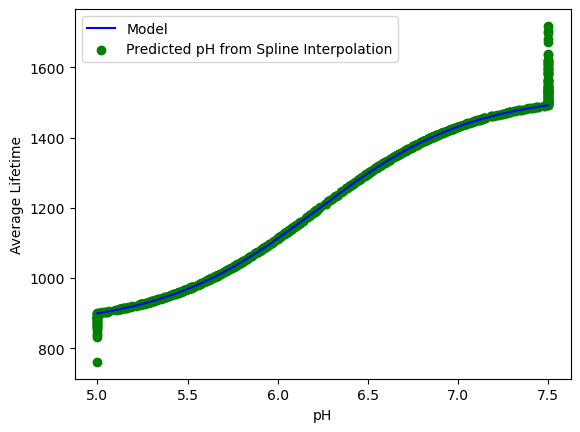

In [3]:

# Load the image data from CSV
image_data_path = Path (r"G:\SP8_FLIM\0_Workflow_OPTIM\pH\Outputs\master_table.csv")
image_data = pd.read_csv(image_data_path)

# Extract mean_tau values as numpy arrays
lifetimes_from_image_data = image_data['mean_tau'].to_numpy()

# Predict pH values for the new lifetimes using the spline interpolation function
predicted_pH_values = spline_interpolator(lifetimes_from_image_data)
predicted_pH_values=np.clip(predicted_pH_values,5.0,7.5)
#print("Predicted pH values (Spline Interpolation):", predicted_pH_values)


# Visualize the original model and the spline interpolation
plt.plot(pH_values, lifetime_values, label='Model', color='blue')
plt.scatter(predicted_pH_values, lifetimes_from_image_data, color='green', label='Predicted pH from Spline Interpolation')
plt.xlabel('pH')
plt.ylabel('Average Lifetime')
plt.legend(loc='upper left')


# Add the pH values as a new column to the DataFrame 
image_data = image_data.assign(predicted_pH_values=predicted_pH_values)
image_data

# Save the DataFrame back to CSV with the new column
#output_path = image_data_path.parent / "master_table_with_ph.csv"
#image_data.to_csv(output_path, index=False)

## Interpolate the lifetime image to pH image map

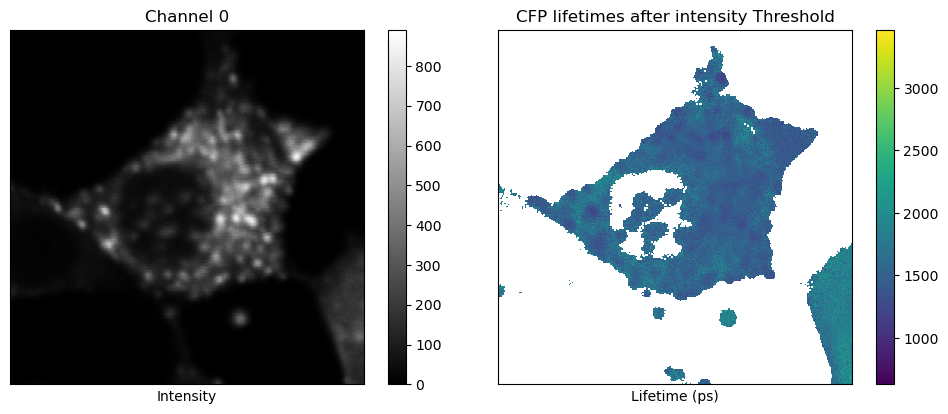

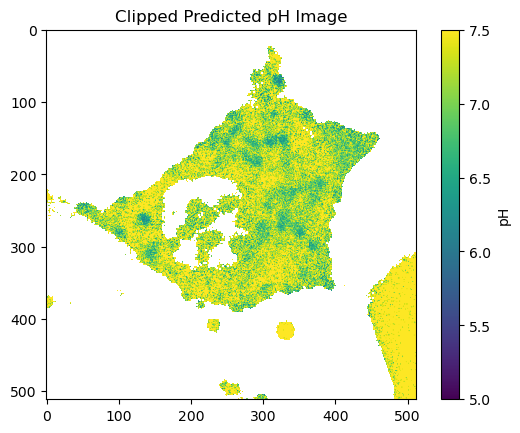

In [30]:
# Read the multichannel image
image = imread(r'../data/Samples/cl2-y3-e-ff.tif')

# Extract the 0 and 1 channels
channel_0 = image[..., 0]
channel_1 = image[..., 1]

# Create a threshold mask based on values in channel 0
threshold_value = 50
mask = channel_0 > threshold_value

# Apply the mask to channel 1
masked_channel_1 = np.where(mask, channel_1, np.nan)  # Use NaN for values below the threshold for visualization purposes

# Display the images side-by-side
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Display channel 0
axs[0].imshow(channel_0, cmap='gray')
axs[0].set_title('Channel 0')
axs[0].set_xlabel('Intensity')
axs[0].set_xticks([])  # Remove x ticks for better visualization
axs[0].set_yticks([])  # Remove y ticks for better visualization
plt.colorbar(axs[0].imshow(channel_0, cmap='gray'), ax=axs[0])

# Display the masked channel 1
axs[1].imshow(masked_channel_1, cmap='viridis')
axs[1].set_title('CFP lifetimes after intensity Threshold')
axs[1].set_xlabel('Lifetime (ps)')
axs[1].set_xticks([])  # Remove x ticks for better visualization
axs[1].set_yticks([])  # Remove y ticks for better visualization
plt.colorbar(axs[1].imshow(masked_channel_1, cmap='viridis'), ax=axs[1])

plt.tight_layout()
plt.show()


predicted_pH_image = spline_interpolator(masked_channel_1)
# Clip the predicted pH values to be within the range [5.0, 7.5]
clipped_pH_image = np.clip(predicted_pH_image, 5.0, 7.5)

# Display the clipped pH image
plt.imshow(clipped_pH_image, cmap='viridis')
plt.title('Clipped Predicted pH Image')
plt.colorbar(label='pH')
plt.show()